<span>
<b>Author:</b> Chenxiang Zhang <br/>
<b>Python version:</b>  3.x <br/>
</span>

## Predictive Analysis
In this notebook, we firstly complete the vendor profile in such a way that it can be used for the predictive analysis. This is done by adding a label to the already existing dataset profile created in the notebook *data_understanding_preparation*. After this, we define the guidelines for the model selection, listing and describing a number of machine learning models for which we want to experiment with. Finally, we evaluate and provide a quantitative and qualitative comparison for all the results.

In [71]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [72]:
df = pd.read_csv('../../data/profile/vendor_profile_log.csv', sep=',', index_col=0)
df.sort_values(by=['revenue_per_day'])

,unique_ram,revenue_per_unit,revenue_per_day,days
vendor_code,,,,
77,1.176091,2.063027,1.079923,2.863917
66,1.146128,2.091103,1.463196,2.352183
61,1.000000,2.000614,1.624519,2.401401
81,0.778151,2.175836,1.793501,1.913814
29,1.681241,2.165335,1.966405,2.864511
...,...,...,...,...
50,3.035029,2.199996,4.091923,2.864511
63,2.697229,2.305917,4.117559,2.818226
45,2.891537,2.302098,4.338090,2.864511


### Vendor Profile: Quantiles Approach
We profile each vendor discretizing each feature into 2-quantiles {0,1} and mapping the sum of features into a new column 'type'. The created column represent the vendor profile. Then we compare the best clustering algorithm's profiling with this approach

In [73]:
# discretize every feature using bi-quantiles
df_profile = pd.DataFrame()
for c in df.columns:
    df_profile[c] = pd.qcut(df[c], q=2, labels=[0,1])
df_profile

,unique_ram,revenue_per_unit,revenue_per_day,days
vendor_code,,,,
1,0,0,0,1
2,1,0,0,1
3,1,0,1,0
4,0,0,1,0
5,1,1,1,0
...,...,...,...,...
77,0,0,0,0
78,0,0,0,1
79,1,0,1,1


In [74]:
# compute vendor profile
# map the values: 0,1,2 -> small vendor
#                 3,4   -> big vendor
vendor_type = df_profile.sum(axis=1)
vendor_type = vendor_type.map({0:'small', 1:'small', 2:'small', 
                               3:'big', 4:'big'})

# dataset with vendor profile computed with quantiles
df_quant = df.copy()
df_quant['type'] = vendor_type
df_quant

# save the file
# df_quant.to_csv('../../data/profile/vendor_profile_quant.csv', sep=',')

,unique_ram,revenue_per_unit,revenue_per_day,days,type
vendor_code,,,,,
1,1.778151,2.120849,2.147317,2.864511,small
2,2.292256,2.171934,2.904020,2.864511,small
3,2.307496,2.189192,4.030182,1.643453,small
4,2.004321,2.151190,3.329420,1.431364,small
5,2.440909,2.218444,3.647152,2.686636,big
...,...,...,...,...,...
77,1.176091,2.063027,1.079923,2.863917,small
78,2.107210,2.040341,2.787765,2.864511,small
79,2.431364,2.185288,3.206421,2.864511,big


In [75]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# normalize the data and reduce the dimension
scaler = StandardScaler()
X = scaler.fit_transform(df)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
df_X = pd.DataFrame(X_pca, columns=['Component0', 'Component1'])
df_X.index = df.index

df_small = df_X[df_quant['type']=='small']
df_big = df_X[df_quant['type']=='big']

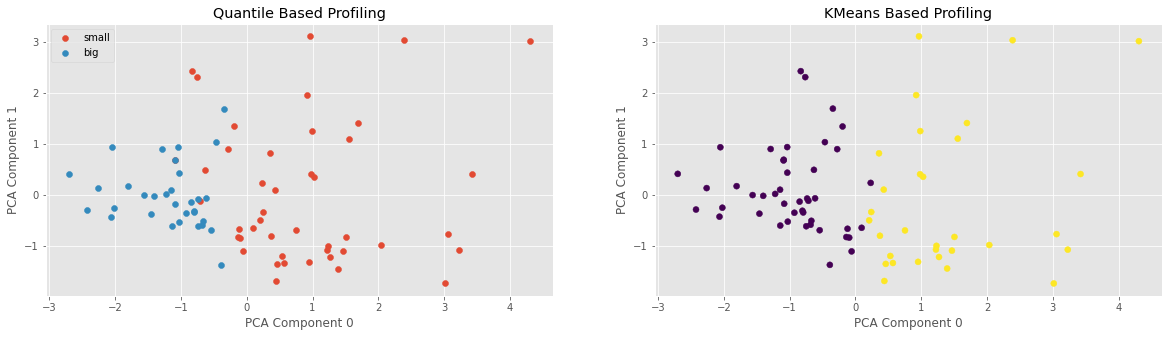

In [76]:
# comparison quantile based profiling approach and KMeans profiling in two dimension
fig = plt.figure(figsize=(20, 5)) 
fig_dims = (1, 2)
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot2grid(fig_dims, (0, 0))
plt.scatter(df_small['Component0'], df_small['Component1'], label='small')
plt.scatter(df_big['Component0'], df_big['Component1'], label='big')
plt.xlabel('PCA Component 0')
plt.ylabel('PCA Component 1')
plt.title('Quantile Based Profiling')
plt.legend()

plt.subplot2grid(fig_dims, (0, 1))
kmeans = KMeans(n_clusters=2, random_state=4)
kmeans.fit(X_pca)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_)
plt.xlabel('PCA Component 0')
plt.ylabel('PCA Component 1')
plt.title('KMeans Based Profiling')

plt.savefig('../../tex/imgs/predict_data_quantiles.pdf')
plt.savefig('../../tex/imgs/predict_data_quantiles.png')

In [77]:
# quantitative measure of two clusters

# the data is scarse and irregular, thus even if the quant approach has
# a lower score we choose this for predictive tasks
from sklearn.metrics import silhouette_score
print('Silhouette Quant: \t', silhouette_score(X_pca, df_quant['type'].values))
print('Silhouette KMeans: \t', silhouette_score(X_pca, kmeans.labels_))

Silhouette Quant: 	 0.28630072212097774
Silhouette KMeans: 	 0.39286431036638936


### Data Splitting and Model Selection
Split the complete dataset into train set (70%) and test set (30%). The split is done in a stratified way to preserve the label's distribution. For model selection we decide to use the grid search to navigate through the space looking for a good set of hyperparameters and we use the cross-validation based on the train set's average result to evaluate the model's performance.
- Stratified K-fold: https://scikit-learn.org/stable/modules/cross_validation.html#stratification

In [78]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, learning_curve, validation_curve
import scipy.stats as stats

In [79]:
quant = df_quant.to_numpy()
X, y = quant[:, :-1], quant[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [80]:
len(y_train[y_train=='big'])/len(y_train)

0.41509433962264153

### Utility Functions
- report() is used to output the characteristic of the best models found by the random search
- plot_learning_curve() is used to plot the learning curve during the validation phase

In [81]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [94]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates[:1]:
            print("Model rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
def plot_learning_curve(pipeline, X, y, cv=4, 
                        train_sizes=np.linspace(.1, 1.0, 5),
                        random_state=None):

    train_sizes, train_scores, test_scores = learning_curve(pipeline, X, y, train_sizes=train_sizes, cv=cv,
                                                            scoring='accuracy', n_jobs=-1,
                                                            random_state=random_state)

    train_score_mean = np.mean(train_scores, axis=1)
    train_score_std = np.std(train_scores, axis=1)
    test_score_mean = np.mean(test_scores, axis=1)
    test_score_std = np.std(test_scores, axis=1)

    plt.title(str(pipeline['estimator'].__class__.__name__) + ' Learning Curve')
    plt.xlabel('Training examples')
    plt.ylabel('Accuracy')

    # clamp values in 0, 1
    train_up = train_score_mean + train_score_std
    train_up = [score if score < 1 else 1 for score in train_up]
    train_down = train_score_mean - train_score_std
#     train_down = [score if score > 0 else 0 for score in train_down]
    
    test_up = test_score_mean + test_score_std
    test_up = [score if score < 1 else 1 for score in test_up]
    test_down = test_score_mean - test_score_std
#     test_down = [score if score > 0 else 0 for score in test_down]
    
    # plot the learning curve
    plt.plot(train_sizes, train_score_mean, label='train score', marker='.')
    plt.fill_between(train_sizes, train_up, train_down, alpha=0.2)
    plt.plot(train_sizes, test_score_mean, label='cross-validation score', marker='.')
    plt.fill_between(train_sizes, test_up, test_down, alpha=0.2)

    print(f'Train score mean: {train_score_mean[-1]}, std: {train_score_std[-1]}')
    print(f'Test score mean: {test_score_mean[-1]}, std: {test_score_std[-1]}')
    
    plt.legend()


### Support Vector Classifier
Searches an hyper plane that can linearly separate the data points in a higher space using the kernel trick.

In [83]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

In [84]:
pipeline = Pipeline([('scaler', StandardScaler()), 
                     ('estimator', SVC())])

hyperparams = {
    'estimator__C': stats.randint(1, 500),
    'estimator__kernel': ['rbf', 'linear', 'poly'],
    'estimator__degree': [3, 4, 5]
}

# uses default stratified KFold for classification
svc_rand = RandomizedSearchCV(pipeline,
                            param_distributions=hyperparams,
                            scoring='accuracy',
                            n_iter=100,
                            cv=4,  
                            n_jobs=-1,  # use all processors
                            refit=True,  # refit the best model at the end
                            return_train_score=True,
                            verbose=True).fit(X_train, y_train)

Fitting 4 folds for each of 100 candidates, totalling 400 fits


In [85]:
report(svc_rand.cv_results_)

Model rank: 1
Mean validation score: 0.887 (std: 0.085)
Parameters: {'estimator__C': 77, 'estimator__degree': 5, 'estimator__kernel': 'rbf'}



Train score mean: 0.9824561403508771, std: 0.012405382126079782
Test score mean: 0.868421052631579, std: 0.09488292830168395


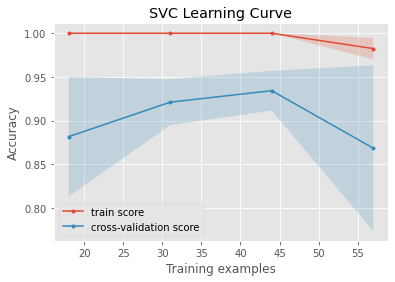

In [95]:
plot_learning_curve(svc_rand.best_estimator_, X, y)
plt.savefig('../../tex/imgs/predict_svm_learning_curve.pdf')
plt.savefig('../../tex/imgs/predict_svm_learning_curve.png')

In [90]:
# evaluation on test set
y_pred = svc_rand.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         big       1.00      0.90      0.95        10
       small       0.93      1.00      0.96        13

    accuracy                           0.96        23
   macro avg       0.96      0.95      0.96        23
weighted avg       0.96      0.96      0.96        23



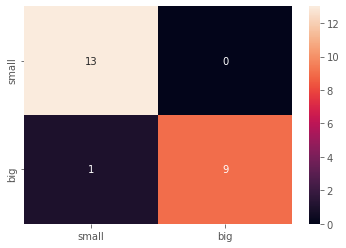

In [91]:
confusion = pd.DataFrame(confusion_matrix(y_test, y_pred, labels=['small', 'big']), 
                         columns=['small', 'big'], index=['small', 'big'])
sns.heatmap(confusion, annot=True)
plt.savefig('../../tex/imgs/predict_svc_confusion.pdf')
plt.savefig('../../tex/imgs/predict_svc_confusion.png')

### Gaussian Naive Bayes
Estimates the class conditional probability for each item using the Bayes theorem. It assumes that all the features distribution are Gaussian and conditionally independent between each other.

In [19]:
from sklearn.naive_bayes import GaussianNB

In [20]:
pipeline = Pipeline([('scaler', StandardScaler()), 
                     ('estimator', GaussianNB())])

hyperparams = {}

nb_rand = RandomizedSearchCV(pipeline,
                            param_distributions=hyperparams,
                            scoring='accuracy',
                            n_iter=1,
                            cv=4,  
                            n_jobs=-1,  # use all processors
                            refit=True,  # refit the best model at the end
                            return_train_score=True,
                            verbose=True).fit(X_train, y_train)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


In [21]:
report(nb_rand.cv_results_)

Model rank: 1
Mean validation score: 0.924 (std: 0.054)
Parameters: {}



Train score mean: 0.9166666666666666, std: 0.025947718346928147
Test score mean: 0.8552631578947368, std: 0.05735393346764042


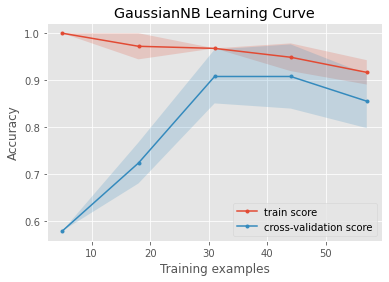

In [96]:
plot_learning_curve(nb_rand.best_estimator_, X, y)
plt.savefig('../../tex/imgs/predict_nb_learning_curve.pdf')
plt.savefig('../../tex/imgs/predict_nb_learning_curve.png')

In [23]:
# evaluation on test set
y_pred = nb_rand.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         big       0.91      1.00      0.95        10
       small       1.00      0.92      0.96        13

    accuracy                           0.96        23
   macro avg       0.95      0.96      0.96        23
weighted avg       0.96      0.96      0.96        23



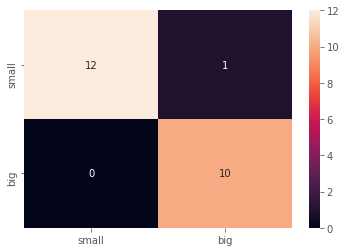

In [24]:
confusion = pd.DataFrame(confusion_matrix(y_test, y_pred, labels=['small', 'big']), 
                         columns=['small', 'big'], index=['small', 'big'])
sns.heatmap(confusion, annot=True)
plt.savefig('../../tex/imgs/predict_nb_confusion.pdf')
plt.savefig('../../tex/imgs/predict_nb_confusion.png')

### K Nearest Neighbor
Find a defined number of training samples closest in distance to the new point, and predict the label from these. 

In [25]:
from sklearn.neighbors import KNeighborsClassifier

In [26]:
pipeline = Pipeline([('scaler', StandardScaler()), 
                     ('estimator', KNeighborsClassifier())])

hyperparams = {
    'estimator__n_neighbors': stats.randint(2, 20),
    'estimator__algorithm': ('ball_tree', 'kd_tree', 'brute')
}

knn_rand = RandomizedSearchCV(pipeline,
                            param_distributions=hyperparams,
                            scoring='accuracy',
                            n_iter=100,
                            cv=4,  
                            n_jobs=-1,  # use all processors
                            refit=True,  # refit the best model at the end
                            return_train_score=True,
                            verbose=True).fit(X_train, y_train)

Fitting 4 folds for each of 100 candidates, totalling 400 fits


In [27]:
report(knn_rand.cv_results_)

Model rank: 1
Mean validation score: 0.924 (std: 0.054)
Parameters: {'estimator__algorithm': 'ball_tree', 'estimator__n_neighbors': 3}



Train score mean: 0.9473684210526315, std: 0.012405382126079782
Test score mean: 0.881578947368421, std: 0.06837042661456093


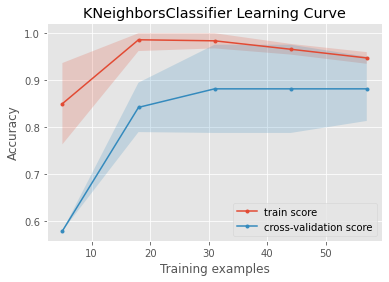

In [97]:
plot_learning_curve(knn_rand.best_estimator_, X, y)
plt.savefig('../../tex/imgs/predict_knn_learning_curve.pdf')
plt.savefig('../../tex/imgs/predict_knn_learning_curve.png')

In [29]:
# evaluation on test set
y_pred = knn_rand.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         big       0.83      1.00      0.91        10
       small       1.00      0.85      0.92        13

    accuracy                           0.91        23
   macro avg       0.92      0.92      0.91        23
weighted avg       0.93      0.91      0.91        23



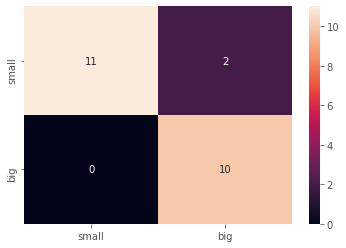

In [30]:
confusion = pd.DataFrame(confusion_matrix(y_test, y_pred, labels=['small', 'big']), 
                         columns=['small', 'big'], index=['small', 'big'])
sns.heatmap(confusion, annot=True)
plt.savefig('../../tex/imgs/predict_knn_confusion.pdf')
plt.savefig('../../tex/imgs/predict_knn_confusion.png')

### Decision Tree
Builds a tree where nodes are decision rules learned from the training data. These rules linearly cut the space until a leaf is reached.

In [31]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [32]:
pipeline = Pipeline([('scaler', StandardScaler()), 
                     ('estimator', DecisionTreeClassifier())])

hyperparams = {
    'estimator__splitter': ('best', 'random'),
    'estimator__max_depth': stats.randint(1, 100),
    'estimator__max_features': ('auto', 'sqrt', 'log2'),
    'estimator__criterion': ('gini', 'entropy'),
    'estimator__random_state': ([5])
}

dt_rand = RandomizedSearchCV(pipeline,
                            param_distributions=hyperparams,
                            scoring='accuracy',
                            n_iter=400,
                            cv=4,  
                            n_jobs=-1,  # use all processors
                            refit=True,  # refit the best model at the end
                            return_train_score=True,
                            verbose=True).fit(X_train, y_train)

Fitting 4 folds for each of 400 candidates, totalling 1600 fits


In [33]:
report(dt_rand.cv_results_)

Model rank: 1
Mean validation score: 0.905 (std: 0.084)
Parameters: {'estimator__criterion': 'gini', 'estimator__max_depth': 2, 'estimator__max_features': 'log2', 'estimator__random_state': 5, 'estimator__splitter': 'best'}

Model rank: 3
Mean validation score: 0.886 (std: 0.067)
Parameters: {'estimator__criterion': 'gini', 'estimator__max_depth': 34, 'estimator__max_features': 'log2', 'estimator__random_state': 5, 'estimator__splitter': 'best'}



Train score mean: 0.9824561403508771, std: 0.012405382126079782
Test score mean: 0.9078947368421052, std: 0.06837042661456096


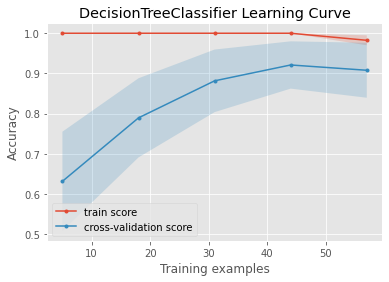

In [98]:
plot_learning_curve(dt_rand.best_estimator_, X, y)
plt.savefig('../../tex/imgs/predict_dt_learning_curve.pdf')
plt.savefig('../../tex/imgs/predict_dt_learning_curve.png')

In [35]:
# evaluation on test set
y_pred = dt_rand.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         big       0.73      0.80      0.76        10
       small       0.83      0.77      0.80        13

    accuracy                           0.78        23
   macro avg       0.78      0.78      0.78        23
weighted avg       0.79      0.78      0.78        23



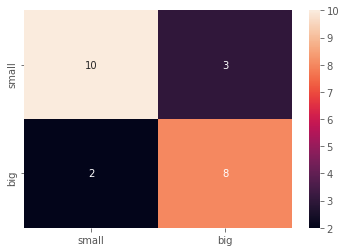

In [36]:
confusion = pd.DataFrame(confusion_matrix(y_test, y_pred, labels=['small', 'big']), 
                         columns=['small', 'big'], index=['small', 'big'])
sns.heatmap(confusion, annot=True)
plt.savefig('../../tex/imgs/predict_dt_confusion.pdf')
plt.savefig('../../tex/imgs/predict_dt_confusion.png')

### Random Forest
Ensemble model, it uses bagging with decision trees. It combines the predictions made by multiple decision trees and outputs the class that is the mode of outputs.

In [37]:
from sklearn.ensemble import RandomForestClassifier

In [38]:
pipeline = Pipeline([('scaler', StandardScaler()), 
                     ('estimator', RandomForestClassifier())])

hyperparams = {
    'estimator__n_estimators': stats.randint(1, 10),
    'estimator__max_depth': stats.randint(1, 100),
    'estimator__max_features': ('auto', 'sqrt', 'log2'),
    'estimator__criterion': ('gini', 'entropy')
}

rf_rand = RandomizedSearchCV(pipeline,
                            param_distributions=hyperparams,
                            scoring='accuracy',
                            n_iter=400,
                            cv=4,  
                            n_jobs=-1,  # use all processors
                            refit=True,  # refit the best model at the end
                            return_train_score=True,
                            verbose=True).fit(X_train, y_train)

Fitting 4 folds for each of 400 candidates, totalling 1600 fits


In [39]:
report(rf_rand.cv_results_)

Model rank: 1
Mean validation score: 0.962 (std: 0.038)
Parameters: {'estimator__criterion': 'gini', 'estimator__max_depth': 76, 'estimator__max_features': 'sqrt', 'estimator__n_estimators': 6}



Train score mean: 0.9912280701754386, std: 0.00877192982456143
Test score mean: 0.9342105263157895, std: 0.06837042661456096


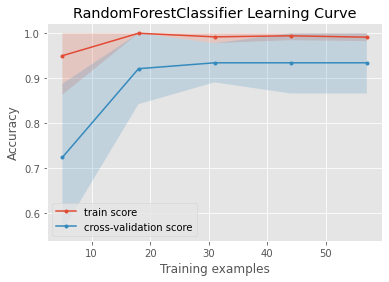

In [99]:
plot_learning_curve(rf_rand.best_estimator_, X, y)
plt.savefig('../../tex/imgs/predict_rf_learning_curve.pdf')
plt.savefig('../../tex/imgs/predict_rf_learning_curve.png')

In [41]:
# evaluation on test set
y_pred = rf_rand.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         big       0.91      1.00      0.95        10
       small       1.00      0.92      0.96        13

    accuracy                           0.96        23
   macro avg       0.95      0.96      0.96        23
weighted avg       0.96      0.96      0.96        23



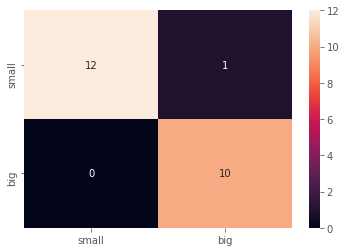

In [42]:
confusion = pd.DataFrame(confusion_matrix(y_test, y_pred, labels=['small', 'big']), 
                         columns=['small', 'big'], index=['small', 'big'])
sns.heatmap(confusion, annot=True)
plt.savefig('../../tex/imgs/predict_rf_confusion.pdf')
plt.savefig('../../tex/imgs/predict_rf_confusion.png')

### Neural Network
Multilayer neural network which learns a new representation of data with each layer. The last layer classifies the original data transformed with all the hidden layers.

In [52]:
from sklearn.neural_network import MLPClassifier

In [61]:
pipeline = Pipeline([('scaler', StandardScaler()), 
                     ('estimator', MLPClassifier())])

hyperparams = {
    'estimator__hidden_layer_sizes': stats.randint(1, 50),
    'estimator__activation': ('logistic', 'tanh', 'relu'),
    'estimator__solver': ('sgd', 'adam'),
    'estimator__learning_rate_init': stats.uniform(0, 0.01),
    'estimator__alpha': stats.uniform(),
    'estimator__max_iter': stats.randint(100, 300)
}

nn_rand = RandomizedSearchCV(pipeline,
                            param_distributions=hyperparams,
                            scoring='accuracy',
                            n_iter=400,
                            cv=4,  
                            n_jobs=-1,  # use all processors
                            refit=True,  # refit the best model at the end
                            return_train_score=True,
                            verbose=True).fit(X_train, y_train)

Fitting 4 folds for each of 400 candidates, totalling 1600 fits


/home/dot/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (291) reached and the optimization hasn't converged yet.
  warnings.warn(


In [62]:
report(nn_rand.cv_results_)

Model rank: 1
Mean validation score: 0.944 (std: 0.033)
Parameters: {'estimator__activation': 'logistic', 'estimator__alpha': 0.6148489937644365, 'estimator__hidden_layer_sizes': 43, 'estimator__learning_rate_init': 0.0055297665290532805, 'estimator__max_iter': 291, 'estimator__solver': 'sgd'}

Model rank: 3
Mean validation score: 0.942 (std: 0.064)
Parameters: {'estimator__activation': 'logistic', 'estimator__alpha': 0.25657347566093613, 'estimator__hidden_layer_sizes': 13, 'estimator__learning_rate_init': 0.007692769149655061, 'estimator__max_iter': 285, 'estimator__solver': 'sgd'}



Train score mean: 0.9342105263157894, std: 0.022790142204853665
Test score mean: 0.868421052631579, std: 0.05884389414473129


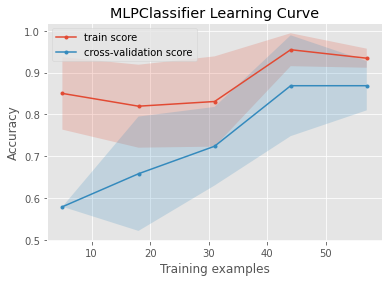

In [100]:
plot_learning_curve(nn_rand.best_estimator_, X, y)
plt.savefig('../../tex/imgs/predict_nn_learning_curve.pdf')
plt.savefig('../../tex/imgs/predict_nn_learning_curve.png')

In [64]:
# evaluation on test set
y_pred = nn_rand.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         big       0.75      0.90      0.82        10
       small       0.91      0.77      0.83        13

    accuracy                           0.83        23
   macro avg       0.83      0.83      0.83        23
weighted avg       0.84      0.83      0.83        23



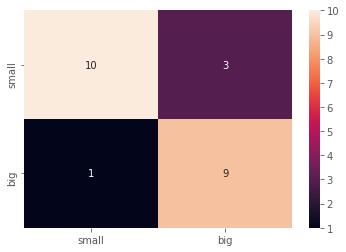

In [65]:
confusion = pd.DataFrame(confusion_matrix(y_test, y_pred, labels=['small', 'big']), 
                         columns=['small', 'big'], index=['small', 'big'])
sns.heatmap(confusion, annot=True)
plt.savefig('../../tex/imgs/predict_nn_confusion.pdf')
plt.savefig('../../tex/imgs/predict_nn_confusion.png')

### Plot All Classifiers Decision Boundary
Provide a visual comparison plotting the decision boundary created by the classifiers. We do so by training all the classifiers proposed previously with the two dimensional data that are preprocessed by the PCA. Doing so, the decision boundary can be visualized easily in a two dimension plot. The hyperparameters of the classifiers are the best hyperparameters returned by the Randomized search.

In [66]:
# training data X_pca, y
y = df_quant['type'].map({'small':0, 'big':1}).values

# create a mesh to plot in
h = 0.2
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

classifiers = [
    svc_rand.best_estimator_,
    nb_rand.best_estimator_,
    knn_rand.best_estimator_,
    dt_rand.best_estimator_,
    rf_rand.best_estimator_,
    nn_rand.best_estimator_
]

/home/dot/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (291) reached and the optimization hasn't converged yet.
  warnings.warn(


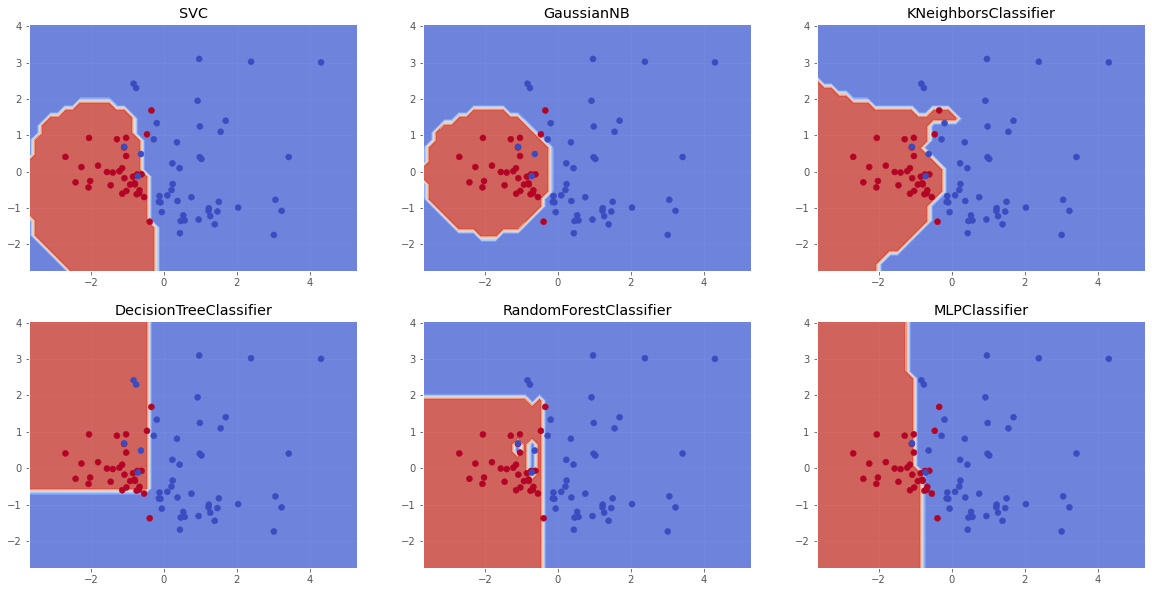

In [67]:
# plot the decision boundary of all the classifiers
fig = plt.figure(figsize=(20, 10)) 
for i, clf in enumerate(classifiers):
    # we will assign a color to each point in the mesh.
    plt.subplot(2, 3, i + 1)
    plt.subplots_adjust(wspace=0.2, hspace=0.2)

    clf.fit(X_pca, y)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

    # plot the training points
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap=plt.cm.coolwarm)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(str(clf['estimator'].__class__.__name__))

In [68]:
fig.savefig('../../tex/imgs/predict_compare_all.pdf')
fig.savefig('../../tex/imgs/predict_compare_all.png')